# Clasificación de la Calidad del Vino - Machine Learning Supervisado

**Autor**: Cristian Alexis Murillo Martínez


**Descripción del Problema**

La industria de vinos busca constantemente mejorar la calidad de sus productos. Un modelo de clasificación de calidad del vino permitiría identificar qué características fisicoquímicas afectan la percepción de calidad y ayudaría a optimizar el proceso de producción. El objetivo de este examen es diseñar un clasificador que prediga la calidad del vino basado en sus características químicas.


**Dataset**

El archivo de datos proporcionado es ``wine quality.csv``. Este archivo contiene un total de 6,497 registros de muestras de vino. Las características del dataset incluyen:
- Acidez fija
- Acidez volátil
- Ácido cítrico
- Azúcares residuales
- Cloruros
- Dióxido de azufre libre
- Dióxido de azufre total
- Densidad
- pH
- Sulfatos
- Alcohol

La variable a predecir es la calidad del vino ``quality``, representada por una escala de 1 a 10, aunque la mayoría de los datos se encuentran en el rango de 3 a 8. Se trata de un problema de clasificación multiclase.


**Contenido**
1. [Configuración del Ambiente](#environment-setup)
2. [Análisis Exploratorio de Datos](#exploratory-data-analysis)
    - Nulos
    - Duplicados
3. [Preprocesamiento](#preprocessing)
    - Mapear las etiquetas a otro rango más conveniente
4. [Modelamiento Base](#baseline)
5. [Selección del Modelo](#model-selection)
    - Pipeline
        - Feature Scaling
    - Hyperparameter Tuning
        - Validación Cruzada
        - RandomizedSearch
6. [Análisis de Resultados](#results)
7. [Conclusiones y Recomendaciones](#recommendations)
---


<a id='environment-setup'></a>
## Configuración del Ambiente
Carga de las librerías a utilizar, además de definir algunas constantes y configuraciones globales del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

In [2]:
# Se usa para desplegar un máximo de 50 columnas en el dataframe.
pd.set_option("display.max_columns", 50)

# Se usa esta semilla para reproducibilidad de los experimentos.
RANDOM_STATE = 50

<a id="exploratory-data-analysis"></a>
## Análisis Exploratorio de Datos

In [ ]:
raw_data = pd.read_csv("./data/wine_quality.csv").drop(columns="Unnamed: 0")
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


Al cargar los datos, se observa que todas las variables son numéricas. Además, son de tipo flotante con excepción de la variable ``quality`` que representa el atributo target u objetivo a predecir.

In [4]:
# Verificando la cantidad de duplicados
duplicados = raw_data.duplicated().sum()
print(f"""
    La cantidad de registros duplicados en los datos es {duplicados}, representando el {duplicados/raw_data.shape[0]:.1%} de los datos.
""")


    La cantidad de registros duplicados en los datos es 1179, representando el 18.1% de los datos.



In [5]:
# Se procede a eliminar los datos duplicados
raw_data.drop_duplicates(inplace=True)
raw_data.shape

(5318, 12)

In [6]:
# Visualizando los primeros 4 registros para familiarizarse con los datos recolectados.
raw_data.head(4)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6


In [7]:
# Verificando la cantidad de nulos
raw_data.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

En este punto ya no hay más presencia ni de duplicados ni de datos faltantes.

### Problema de Clasificación Desbalanceado

La imagen de la siguiente celda muestra que la calidad de los vinos se distribuye de manera visualmente parecida a una campana Gausiana. En donde las clases 3 y 9 se encuentran muy fuertemente sub-representadas, con 30 y 5 ejemplos respectivamente.

quality
3      30
4     206
5    1751
6    2323
7     855
8     148
9       5
Name: count, dtype: int64


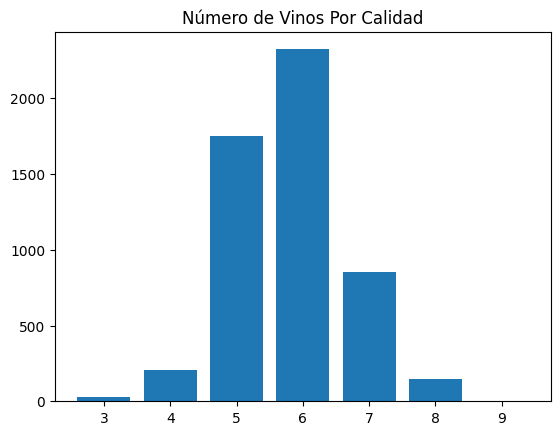

In [8]:
conteo_calidad = raw_data.quality.value_counts().sort_index()

print(conteo_calidad)

plt.figure()
plt.title("Número de Vinos Por Calidad")
plt.bar(conteo_calidad.index, conteo_calidad.values)
plt.xticks(conteo_calidad.index)
plt.show()

En este punto se toma la decisión de remover la clase 9 debido a que tiene muy pocos datos (5) para ser aprendida con algún algoritmo de machine learning. Incluso las técnicas de sobremuestreo no ayudarían debido a que hay muy pocos datos para interpolar/inferir nuevas instancias. El uso de sobremuestreo simplemente añadirá ruido al modelo provocando que se degrade su desempeño.

In [17]:
data = raw_data.loc[raw_data.quality!=9].copy()
data.shape

(5313, 12)

### Train - Test Split

Realizo la división entre los conjuntos de entrenamiento y prueba en este punto ya que quiero evitar el error de analizar los datos de prueba, lo que podría influir en mi selección del modelo o preprocesamiento. A este fenómeno se le conoce como **data leakage**. La división temprana de los conjuntos de datos asegura que el set de prueba sea tratado efectivamente como datos nunca vistos.

La división de los datos se realiza con el parámetro ``stratify=data['quality']`` para asegurarse que la distribución de las clases se preserve en ambos conjuntos de datos. Adicionalmente, se usa un 20% para el set de prueba.

In [18]:
train, test = train_test_split(
    data, test_size=0.2, random_state=RANDOM_STATE, stratify=data['quality'] 
)

train.shape, test.shape

((4250, 12), (1063, 12))

A continuación, se analizan algunas estadísticas del conjunto de entrenamiento.

In [19]:
train.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,7.206082,0.342278,0.317360,5.057847,0.056188,30.066706,114.112353,0.994514,3.224979,0.531774,10.555097,5.792235
std,1.312679,0.165634,0.146348,4.519706,0.034720,17.875168,56.429309,0.002972,0.159873,0.147054,1.178280,0.874516
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,17.000000,76.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.295000,0.310000,2.800000,0.047000,28.000000,116.000000,0.994600,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.390000,7.500000,0.066000,41.000000,153.000000,0.996748,3.330000,0.600000,11.333333,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.610000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,8.000000


Algunos rangos:

```python
density = [0.987110 - 1.038980]
residual_sugar = [0.6 - 65.8]
total_sulfur_dioxide = [6.0 - 440.0]
```

La tabla anterior muestra que los atributos presentan diferencias significativas en sus rangos. Es posible que sea necesario escalar los datos, especialmente para algoritmos que usen optimización por descenso de gradiente, lo cual hace más eficiente la convergencia. No obstante, existen otros algoritmos como los basados en árboles que no necesitan de dicho escalamiento de los datos.

En este estudio se realiza escalamiento por temas de consistencia a través de los varios algoritmos que serán probados para construir el mejor clasificador.

A continuación, se muestran los coeficientes de correlación de Pearson para las variables en los datos.

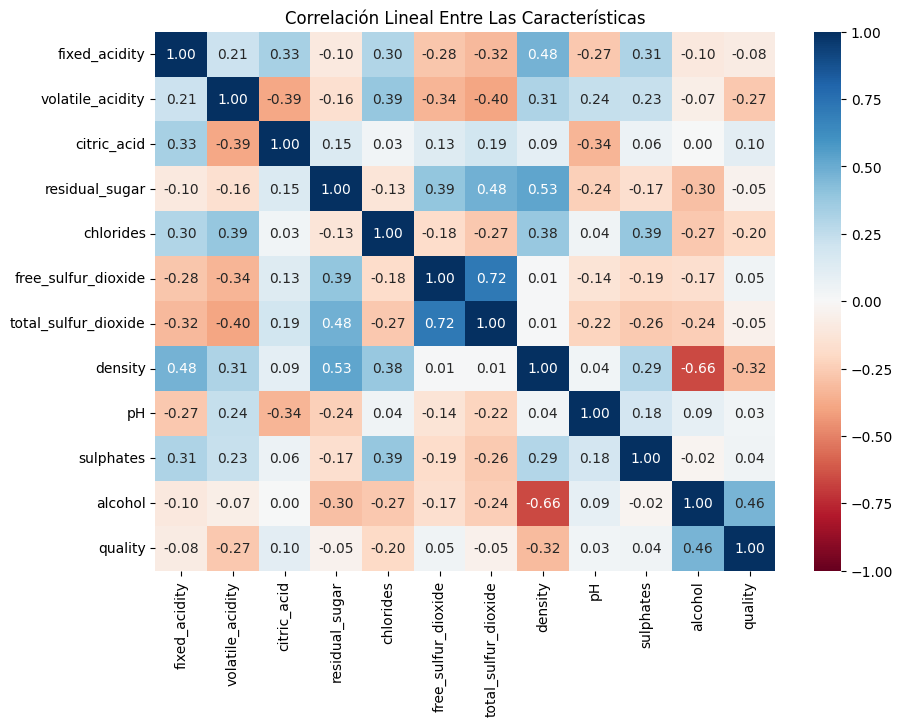

In [20]:
linear_correlations = train.corr()

plt.figure(figsize=(10,7))
plt.title("Correlación Lineal Entre Las Características")
m1 = sns.heatmap(linear_correlations, vmin=-1, vmax=1, annot=True,
                 cmap="RdBu", fmt='.2f')
plt.show()

In [21]:
linear_correlations["quality"]

fixed_acidity          -0.081807
volatile_acidity       -0.268348
citric_acid             0.102315
residual_sugar         -0.045945
chlorides              -0.202146
free_sulfur_dioxide     0.045361
total_sulfur_dioxide   -0.050511
density                -0.316149
pH                      0.033155
sulphates               0.042616
alcohol                 0.463128
quality                 1.000000
Name: quality, dtype: float64

Del mapa de calor y la tabla anterior se puede observar que:
- Existen variables que se encuentran correlacionadas positiva y negativamente, por ejemplo:
    - Correlaciones positivas: free_sulfur_dioxide & total_sulfur_dioxide: 0.72 | fixed_acidity & density: 0.48 | residual_sugar & density: 0.56
        - La correlación entre el dióxido de azufre total & libre es lo suficientemente alta que podría considerarse remover una de las dos variables. En este caso preservaremos ambas ya que existe un porcentaje significativo de variabilidad (30%) que no es explicado.
    - Correlaciones negativas: alcohol & density: -0.66

- Analizando la última columna de la matriz se observan las correlaciones de la variable objetivo ``quality`` con todas las demás. Posiblemente la correlación más fuerte es con el ``alcohol`` = 0.46, lo que sugiere que esta variable sería una buena predictora.


A continuación, se observan las gráficas de dispersión cruzadas entre todas las variables. Las imágenes muestran correlaciones leves entre las variables, misma conclusión alcanzada con el análisis de correlación.

<Figure size 640x480 with 0 Axes>

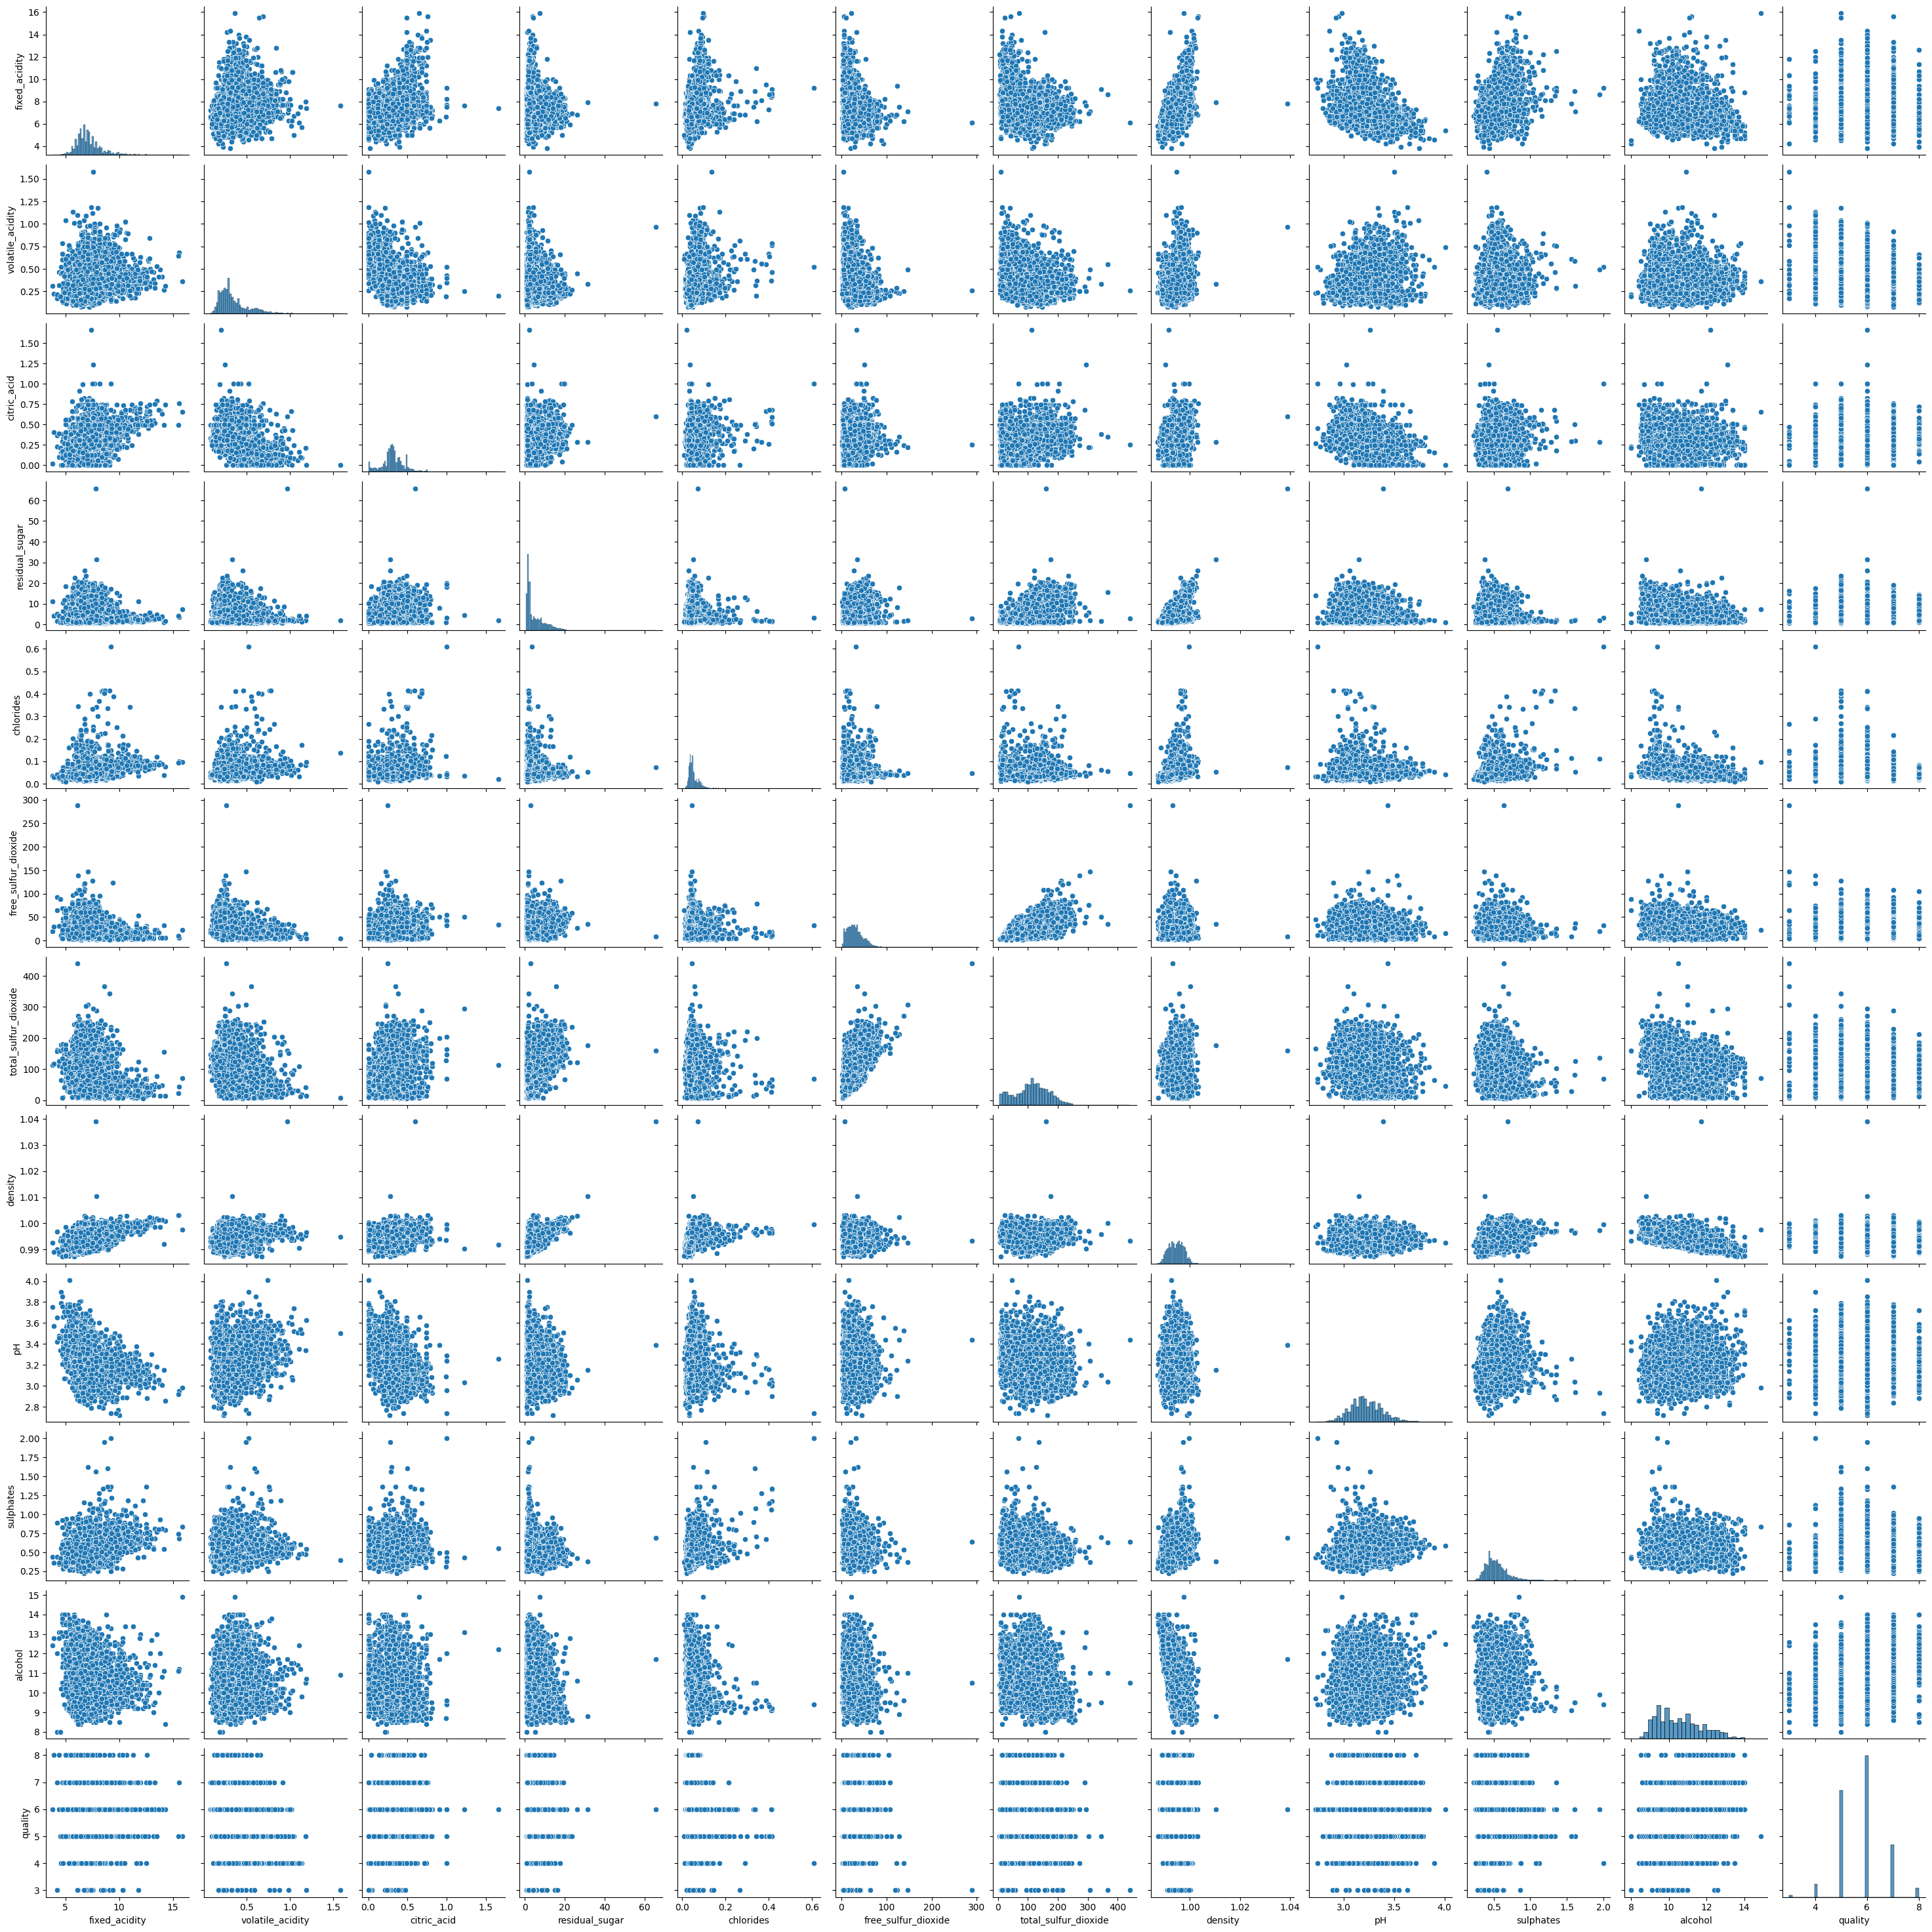

In [24]:
plt.figure()
pp = sns.pairplot(train)
plt.show()

<a id=preprocessing></a>
## Preprocesamiento

Algunos algoritmos obligan a que las etiquetas o números de las clases inicien desde cero, es decir ``[0, 1, 2, ...]`` en lugar de ``[3, 4, 5 ...]``. Por este motivo, se realiza el mapeo tanto a los datos de entrenamiento como prueba. Esta transformación puede ser revertida al momento de analizar los resultados.

In [25]:
train.quality.value_counts().sort_index()

quality
3      24
4     165
5    1401
6    1858
7     684
8     118
Name: count, dtype: int64

In [27]:
X_train = train.drop(columns="quality")
y_train = train["quality"]

X_test = test.drop(columns="quality")
y_test = test["quality"]

first_class_value = y_train.min()

y_train -= first_class_value
y_test -= first_class_value

print(f"{first_class_value=}. {y_train.unique()=}")

first_class_value=np.int64(0). y_train.unique()=array([4, 3, 2, 0, 5, 1])


<a id=baseline></a>
## Modelamiento Base

Construcción de un modelo sencillo que permita estimar los resultados esperados. En la práctica, se recomienda realizar un prototipado para evaluar si la metodología general funciona y comprender qué esperar del modelo.

La **métrica de desempeño** principal a utilizar es el **f1-macro**, el cual se calcula como el promedio aritmético de los **f1_scores** para cada subclase.
- Esta métrica es mucho más robusta para casos de desbalance de clases que el uso de la **accuracy**, la cual está sesgada por la alta exactitud en las clases más representadas.

In [28]:
# Entrenar un modelo simple de Gaussian Naive Bayes
nb = GaussianNB()

nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print(classification_report(y_test, y_pred))

print(f"Overall Accuracy {accuracy_score(y_test, y_pred):.2f}")
print(f"F1-Macro {f1_score(y_test, y_pred, average='macro'):.2f}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.07      0.10      0.08        41
           2       0.54      0.61      0.57       350
           3       0.54      0.37      0.44       465
           4       0.35      0.57      0.44       171
           5       0.25      0.03      0.06        30

    accuracy                           0.46      1063
   macro avg       0.29      0.28      0.26      1063
weighted avg       0.48      0.46      0.46      1063

Overall Accuracy 0.46
F1-Macro 0.26


El primer clasificador muestra un ``f1_macro = 0.26`` y ``accuracy = 0.46``. Este modelo sirve para comparación de línea base. Posteriormente se utilizarán otros modelos más avanzados y se optimizarán los hiperparámetros para obtener el modelo que mejor represente nuestros datos en el espacio de búsqueda.

<a id=model-selection></a>
## Selección de Modelo

El mejor modelo se determina por medio de una búsqueda extensa en un espacio de modelos. A continuación, se describe el pipeline y el método de búsqueda usados:

El Pipeline consiste de los siguientes pasos:
- **imputación**: Aunque los datos de entrenamiento y prueba no tienen datos faltantes, se deja un imputador sencillo como salvaguarda para casos en donde los datos nuevos sí carezcan de algunos valores.
- **Escalamiento**: Como se mencionó en el [EDA](#exploratory-data-analysis), se realiza escalamiento por medio del método de estandarización por consistencia en la evaluación de los diferentes modelos.
- **Re-Muestreo**: Entrenamiento sin remuestreo y con remuestreo usando SMOTE.
- **Modelos**: Se evalúan múltiples modelos de complejidad variable
    - LogisticRegression
    - DecisionTreeClassifier
    - RandomForestClassifier
    - XGBClassifier
    - MLPClassifier


Selección del mejor modelo:
- **RandomizedSearchCV**: Seleccionado en vez de GridSearchCV debido al tamaño del espacio de búsqueda.
- **StratifiedKFold**: Útil para crear KFolds cuando se tratan desbalance de clases. 
- **Scoring**: ``f1_macro`` y ``f1_weighted``. Considera el trade-off entre la precisión y el recall. Es adecuado para escenarios con desbalance de clases.
- **Hiperparámetros**: En el espacio de modelos propuesto, se observa que se prueban múltiples casos tales como:
    - Modelos base
    - Modelos con remuestreo (SMOTE)
    - Modelos incorporando pesos o costos (class_weight='balanced')
    - Diferentes tipos de regularización (L1, L2), y niveles de regularización (parámetros C, reg_lambda)
    - Múltiples solvers ('lbfgs', 'liblinear', 'saga', )
    - Tasas de aprendizaje (learning_rate)
    - Funciones de activación ('relu', 'logistic').
    - Otros específicos a cada algoritmo.


In [ ]:
def identity_function(X):
    return X


kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
lr = LogisticRegression(random_state=RANDOM_STATE)
nb = GaussianNB()
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
rf = RandomForestClassifier(random_state=RANDOM_STATE)
xgb = XGBClassifier(random_state=RANDOM_STATE)
mlp = MLPClassifier(random_state=RANDOM_STATE)

identity_transformer = FunctionTransformer(identity_function)

pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scale", StandardScaler()),
        ("sampling", identity_transformer),
        ("model", nb),
    ]
)

param_dist = [
    {  # Logistic Regression
        'sampling': [SMOTE(random_state=RANDOM_STATE, k_neighbors=3)],
        'sampling__k_neighbors': [3, 4, 5],
        'model': [lr],
        'model__class_weight': [None, "balanced"],
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['lbfgs', 'liblinear', 'saga'],
    },
    {  # Decision Tree
        'sampling': [SMOTE(random_state=RANDOM_STATE, k_neighbors=3)],
        'sampling__k_neighbors': [3, 4, 5],
        'model': [dt],
        'model__class_weight': [None, "balanced"],
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [None, 5, 10, 20],
    },
    {  # Random Forest
        'sampling': [SMOTE(random_state=RANDOM_STATE, k_neighbors=3)],
        'sampling__k_neighbors': [3, 4, 5],
        'model': [rf],
        'model__class_weight': [None, "balanced"],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [2, 5, 10, 20],
        'model__min_samples_split': [2, 3],
    },
    {  # XGBoost
        'sampling': [SMOTE(random_state=RANDOM_STATE, k_neighbors=3)],
        'sampling__k_neighbors': [3, 4, 5],
        'model': [xgb],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [2, 6, 10],
        'model__learning_rate': [0.01, 0.1, 0.7],
        'model__reg_lambda': [0.01, 0.1, 1, 10, 30],
    },
    {  # MLP
        'sampling': [SMOTE(random_state=RANDOM_STATE, k_neighbors=3)],
        'sampling__k_neighbors': [3, 4, 5],
        'model': [mlp],
        'model__activation': ['relu', 'logistic'],
        'model__learning_rate': ['constant', 'adaptive'],
        'model__learning_rate_init': [0.001, 0.01, 0.1],
    },
]

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    cv=kfold,
    n_iter=200,
    scoring=["f1_macro", "f1_weighted"],
    refit="f1_macro",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
)

search.fit(X_train, y_train)

In [ ]:
print(f"Best f1-macro score: {search.best_score_:.2f}")
print(f"Best Parameters: {search.best_params_}")

Best f1-macro score: 0.34
Best Parameters: {'sampling__k_neighbors': 4, 'sampling': SMOTE(k_neighbors=3, random_state=50), 'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__max_depth': 20, 'model__class_weight': 'balanced', 'model': RandomForestClassifier(random_state=50)}


<a id=results></a>
## Análisis de Resultados

Se evaluaron 200 diferentes combinaciones de modelos y preprocesamiento de los datos. El mejor modelo obtenido utilizando las métricas de ``f1_macro & f1_weighted`` fue **RandomForestClassifier**

```Python
Best Parameters: {'sampling__k_neighbors': 4, 'sampling': SMOTE(k_neighbors=3, random_state=50), 'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__max_depth': 20, 'model__class_weight': 'balanced', 'model': RandomForestClassifier(random_state=50)}
```

In [88]:
cv_results = pd.DataFrame(search.cv_results_).sort_values("rank_test_f1_macro")
cv_results['base_algorithm'] = cv_results.param_model.apply(
    lambda x: type(x).__name__
)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sampling__k_neighbors,param_sampling,param_model__n_estimators,param_model__min_samples_split,param_model__max_depth,param_model__class_weight,param_model,param_model__reg_lambda,param_model__learning_rate,param_model__solver,param_model__penalty,param_model__C,param_model__learning_rate_init,param_model__activation,param_model__criterion,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,base_algorithm
105,9.999392,0.114538,0.188830,0.024873,4,"SMOTE(k_neighbors=3, random_state=50)",200.0,2.0,20,balanced,RandomForestClassifier(random_state=50),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'sampling__k_neighbors': 4, 'sampling': SMOTE...",0.332847,0.358321,0.340687,0.343952,0.010653,1,0.530090,0.530983,0.516955,0.526009,0.006413,6,RandomForestClassifier
88,16.055634,0.217320,0.322266,0.027909,3,"SMOTE(k_neighbors=3, random_state=50)",300.0,2.0,20,None,RandomForestClassifier(random_state=50),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'sampling__k_neighbors': 3, 'sampling': SMOTE...",0.329974,0.362297,0.328760,0.340343,0.015531,2,0.529133,0.534766,0.524326,0.529408,0.004266,3,RandomForestClassifier
0,8.106318,0.329502,0.224496,0.028016,3,"SMOTE(k_neighbors=3, random_state=50)",200.0,3.0,20,None,RandomForestClassifier(random_state=50),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'sampling__k_neighbors': 3, 'sampling': SMOTE...",0.330049,0.358038,0.328682,0.338923,0.013528,3,0.532725,0.534146,0.521417,0.529429,0.005695,1,RandomForestClassifier
71,9.851951,0.123740,0.227668,0.033874,3,"SMOTE(k_neighbors=3, random_state=50)",200.0,3.0,20,balanced,RandomForestClassifier(random_state=50),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'sampling__k_neighbors': 3, 'sampling': SMOTE...",0.330049,0.358038,0.328682,0.338923,0.013528,3,0.532725,0.534146,0.521417,0.529429,0.005695,1,RandomForestClassifier
40,4.783825,0.122060,0.077482,0.005457,3,"SMOTE(k_neighbors=3, random_state=50)",100.0,2.0,20,balanced,RandomForestClassifier(random_state=50),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'sampling__k_neighbors': 3, 'sampling': SMOTE...",0.334973,0.354973,0.325899,0.338615,0.012146,5,0.522570,0.527589,0.521627,0.523929,0.002617,7,RandomForestClassifier
39,4.796990,0.119107,0.075296,0.006068,3,"SMOTE(k_neighbors=3, random_state=50)",100.0,2.0,20,None,RandomForestClassifier(random_state=50),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'sampling__k_neighbors': 3, 'sampling': SMOTE...",0.334973,0.354973,0.325899,0.338615,0.012146,5,0.522570,0.527589,0.521627,0.523929,0.002617,7,RandomForestClassifier
28,5.052839,0.095292,0.125800,0.012050,4,"SMOTE(k_neighbors=3, random_state=50)",100.0,3.0,20,None,RandomForestClassifier(random_state=50),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'sampling__k_neighbors': 4, 'sampling': SMOTE...",0.324671,0.344582,0.338807,0.336020,0.008364,7,0.522961,0.508233,0.515015,0.515403,0.006019,20,RandomForestClassifier
108,4.976476,0.197145,0.076426,0.003943,5,"SMOTE(k_neighbors=3, random_state=50)",100.0,3.0,20,balanced,RandomForestClassifier(random_state=50),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'sampling__k_neighbors': 5, 'sampling': SMOTE...",0.324597,0.347171,0.334248,0.335339,0.009248,8,0.513893,0.514583,0.515368,0.514615,0.000603,26,RandomForestClassifier
99,7.941936,0.192128,0.147238,0.010688,3,"SMOTE(k_neighbors=3, random_state=50)",200.0,2.0,10,None,RandomForestClassifier(random_state=50),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'sampling__k_neighbors': 3, 'sampling': SMOTE...",0.356785,0.331933,0.316029,0.334916,0.016772,9,0.504552,0.483686,0.481763,0.490000,0.010319,65,RandomForestClassifier
133,7.902421,0.100656,0.129201,0.012092,3,"SMOTE(k_neighbors=3, random_state=50)",200.0,2.0,10,balanced,RandomForestClassifier(random_state=50),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'sampling__k_neighbors': 3, 'sampling': SMOTE...",0.35678

In [90]:
cv_results.groupby("base_algorithm", as_index=False).agg(
    {
        "rank_test_f1_macro": "mean",
        "rank_test_f1_weighted": "mean",
        "mean_test_f1_macro": "mean",
        "mean_test_f1_weighted": "mean",
     }).sort_values("rank_test_f1_macro")

,base_algorithm,rank_test_f1_macro,rank_test_f1_weighted,mean_test_f1_macro,mean_test_f1_weighted
3,RandomForestClassifier,78.075000,94.875000,0.281957,0.413317
4,XGBClassifier,90.641026,86.162393,0.291683,0.452696
2,MLPClassifier,95.250000,94.250000,0.293681,0.456949
0,DecisionTreeClassifier,141.272727,134.181818,0.250495,0.383266
1,LogisticRegression,167.625000,165.041667,0.240729,0.358776


Los resultados de la correlación cruzada también muestran que los modelos basados en **RandomForest** dominaron la parte superior de la tabla. El mejor modelo obtuvo un ``f1_macro = 0.343952`` y ``f1_weighted = 0.529429``.
- El **f1_macro** calcula el promedio aritmético entre los **f1_scores** de las diferentes clases (es decir, todas las clases pesan igual).
- El **f1_weighted** calcula el promedio ponderado entre los **f1_scores** de las diferentes clases (es decir, las clases son pesadas por el número de instancias correctas en cada clase).

El segundo algoritmo con mejores resultados fue **XGBoost**, tercero **MultiLayerPerceptron Classifier**, cuarto **DecisionTrees** y por último **LogisticRegression**.

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.13      0.20      0.16        41
           5       0.57      0.60      0.59       350
           6       0.55      0.47      0.51       465
           7       0.43      0.49      0.45       171
           8       0.11      0.13      0.12        30

    accuracy                           0.49      1063
   macro avg       0.30      0.31      0.30      1063
weighted avg       0.51      0.49      0.50      1063

Overall Accuracy 0.49
F1-Macro 0.30
F1-Weighted 0.50


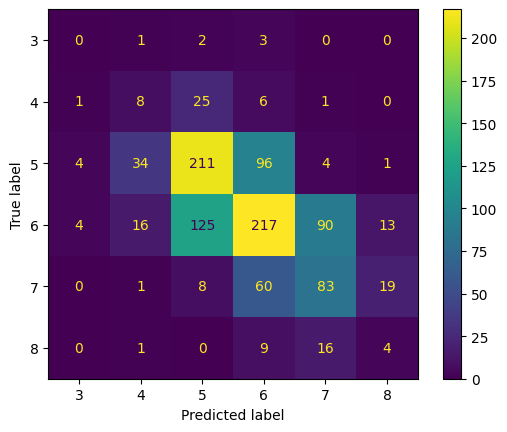

In [97]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['3', '4', '5', '6', '7', '8']))
print(f"Overall Accuracy {accuracy_score(y_test, y_pred):.2f}")
print(f"F1-Macro {f1_score(y_test, y_pred, average='macro'):.2f}")
print(f"F1-Weighted {f1_score(y_test, y_pred, average='weighted'):.2f}")

cm = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=['3', '4', '5', '6', '7', '8']
)

cm.plot()

Las etiquetas de las matrices de clasificación y de confusión anteriores han sido reconvertidas a sus valores originales (i.e. ``[0 -> 3, 1 -> 2, ..., 5 -> 8]``). De estas matrices se observa que:

- Aún el mejor modelo produce una gran cantidad de falsos negativos y falsos positivos. Indicando que todavía habrían otras estratégias que podrían explorarse para intentar mejorar los resultados.
- Los mejores resultados se obtienen para los vinos con calidades 5, 6, 7, respectivamente; lo que es de esperarse puesto que son las clases con más muestras en los datos. Aunque la clase 6 tiene más instancias que la 5 y se esperaría mejor desempeño.

<a id=recommendations></a>
## Conclusiones y Recomendaciones

- Se tomó la decisión de remover la clase 9 debido a que tiene muy pocos datos (5) para ser aprendida con algún algoritmo de machine learning. Incluso las técnicas de sobremuestreo no ayudarían debido a que hay muy pocos datos para interpolar/inferir nuevas instancias. El uso de sobremuestreo simplemente añadirá ruido al modelo provocando que se degrade su desempeño.
    - Para aplicaciones en casos reales se sugiere recolectar más datos para esta clase de modo que pueda ser aprendida correctamente. La misma consideración para las demás clases sub-representadas.

- La **métrica de desempeño** principal a utilizar es el **f1-macro**, el cual se calcula como el promedio aritmético de los **f1_scores** para cada subclase.
    - Esta métrica es mucho más robusta para casos de desbalance de clases que el uso de la **accuracy**, la cual está sesgada por la alta exactitud en las clases más representadas.

- Los resultados de la correlación cruzada también muestran que los modelos basados en **RandomForest** dominaron la parte superior de la tabla. El mejor modelo obtuvo un ``f1_macro = 0.343952`` y ``f1_weighted = 0.529429``.
    - El **f1_macro** calcula el promedio aritmético entre los **f1_scores** de las diferentes clases (es decir, todas las clases pesan igual).
    - El **f1_weighted** calcula el promedio ponderado entre los **f1_scores** de las diferentes clases (es decir, las clases son pesadas por el número de instancias correctas en cada clase).

- El segundo algoritmo con mejores resultados fue **XGBoost**, tercero **MultiLayerPerceptron Classifier**, cuarto **DecisionTrees** y por último **LogisticRegression**.

- Al evaluar finalmente la generalización del mejor modelo en los datos de prueba, se observa que:
    - Aún el mejor modelo produce una gran cantidad de falsos negativos y falsos positivos. Indicando que todavía habrían otras estratégias que podrían explorarse para intentar mejorar los resultados.
    - Los mejores resultados se obtienen para los vinos con calidades 5, 6, 7, respectivamente; lo que es de esperarse puesto que son las clases con más muestras en los datos. Aunque la clase 6 tiene más instancias que la 5 y se esperaría mejor desempeño.

- Algunas recomendaciones adicionales para mejorar el desempeño del modelo son:
    - Dada la fuerte naturaleza desbalanceada de los datos, se debería recolectar más datos para las clases sub-representadas.
    - Se debe definir anticipadamente qué es más importante para alcanzar los objetivos del negocio, de modo se que seleccione correctamente la métrica a optimizar.
    - Ampliar el espacio de búsqueda para explorar modelos que se puedan ajustar mejor a los datos y a su vez, ofrezcan mejor generalización.